In [1]:
import pandas as pd 
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split 

## Загрузка данных

In [185]:
df=pd.read_csv('boston.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


## Подготовка датасета

In [176]:
def plot_target(df):
    n_rows=int(np.ceil((df.shape[1])/6))
    fig,axes=plt.subplots(n_rows,6,sharey=True,figsize=(18,n_rows*3))

    i=0
    for col in df.columns:
        axes[i//6,i%6].scatter(df[col],df['MEDV'],alpha=0.5)
        axes[i//6,i%6].set_xlabel(col)
        axes[i//6,i%6].set_ylabel('MEDV')
        i+=1

    plt.tight_layout()

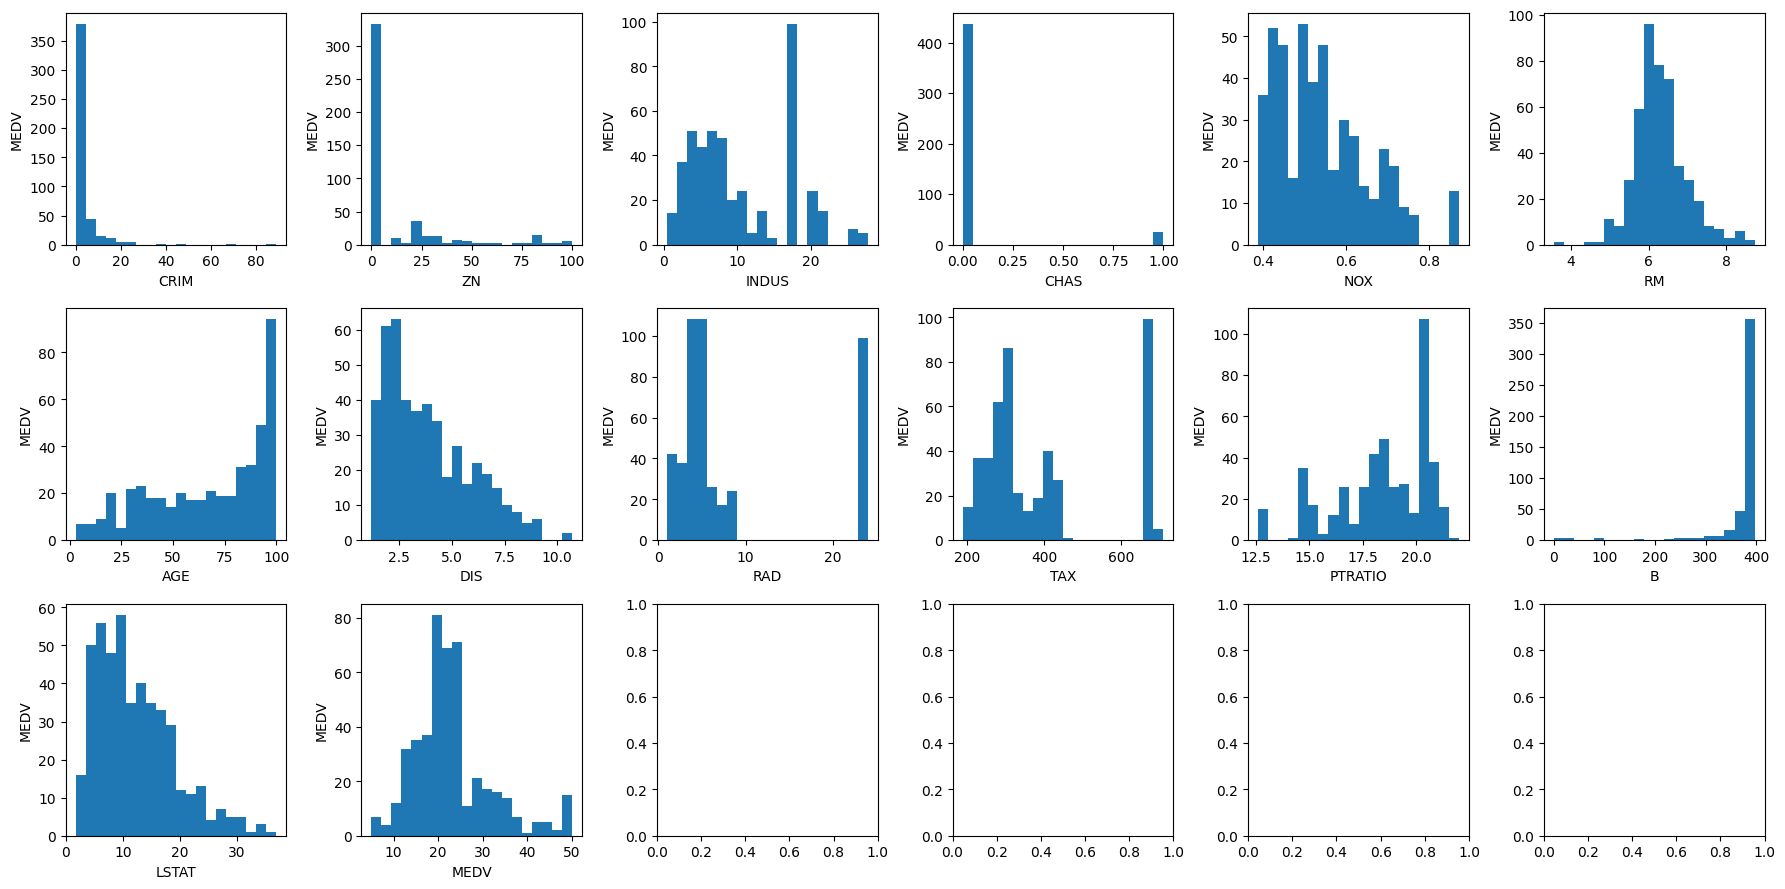

In [177]:
def plot_hists(df):
    n_rows=int(np.ceil((df.shape[1])/6))
    fig,axes=plt.subplots(n_rows,6,figsize=(18,n_rows*3))

    i=0
    for col in df.columns:
        axes[i//6,i%6].hist(df[col],bins=20)
        axes[i//6,i%6].set_xlabel(col)
        axes[i//6,i%6].set_ylabel('MEDV')
        i+=1
    plt.tight_layout()

plot_hists(df)

Добавляем новые столбцы для борьбы с скашиванием

In [186]:
new_df=df.copy()
new_df['log_LSTAT']=new_df['LSTAT'].apply(np.log)
new_df['minus_log2_B']=np.log(np.log(400-new_df['B']))
new_df['log_DIS']=np.log(new_df['DIS'])
new_df['log2_CRIM']=np.log(np.log(new_df['CRIM']+1))
new_df['log_INDUS']=np.log(5-np.log(new_df['INDUS']))
new_df['minus_log_AGE']=np.log(108-new_df['AGE'])
new_df['log2_ZN']=np.log(np.log(new_df['ZN']+1)+1)
new_df['log2_NOX']=np.log(np.log(new_df['NOX'])+2)

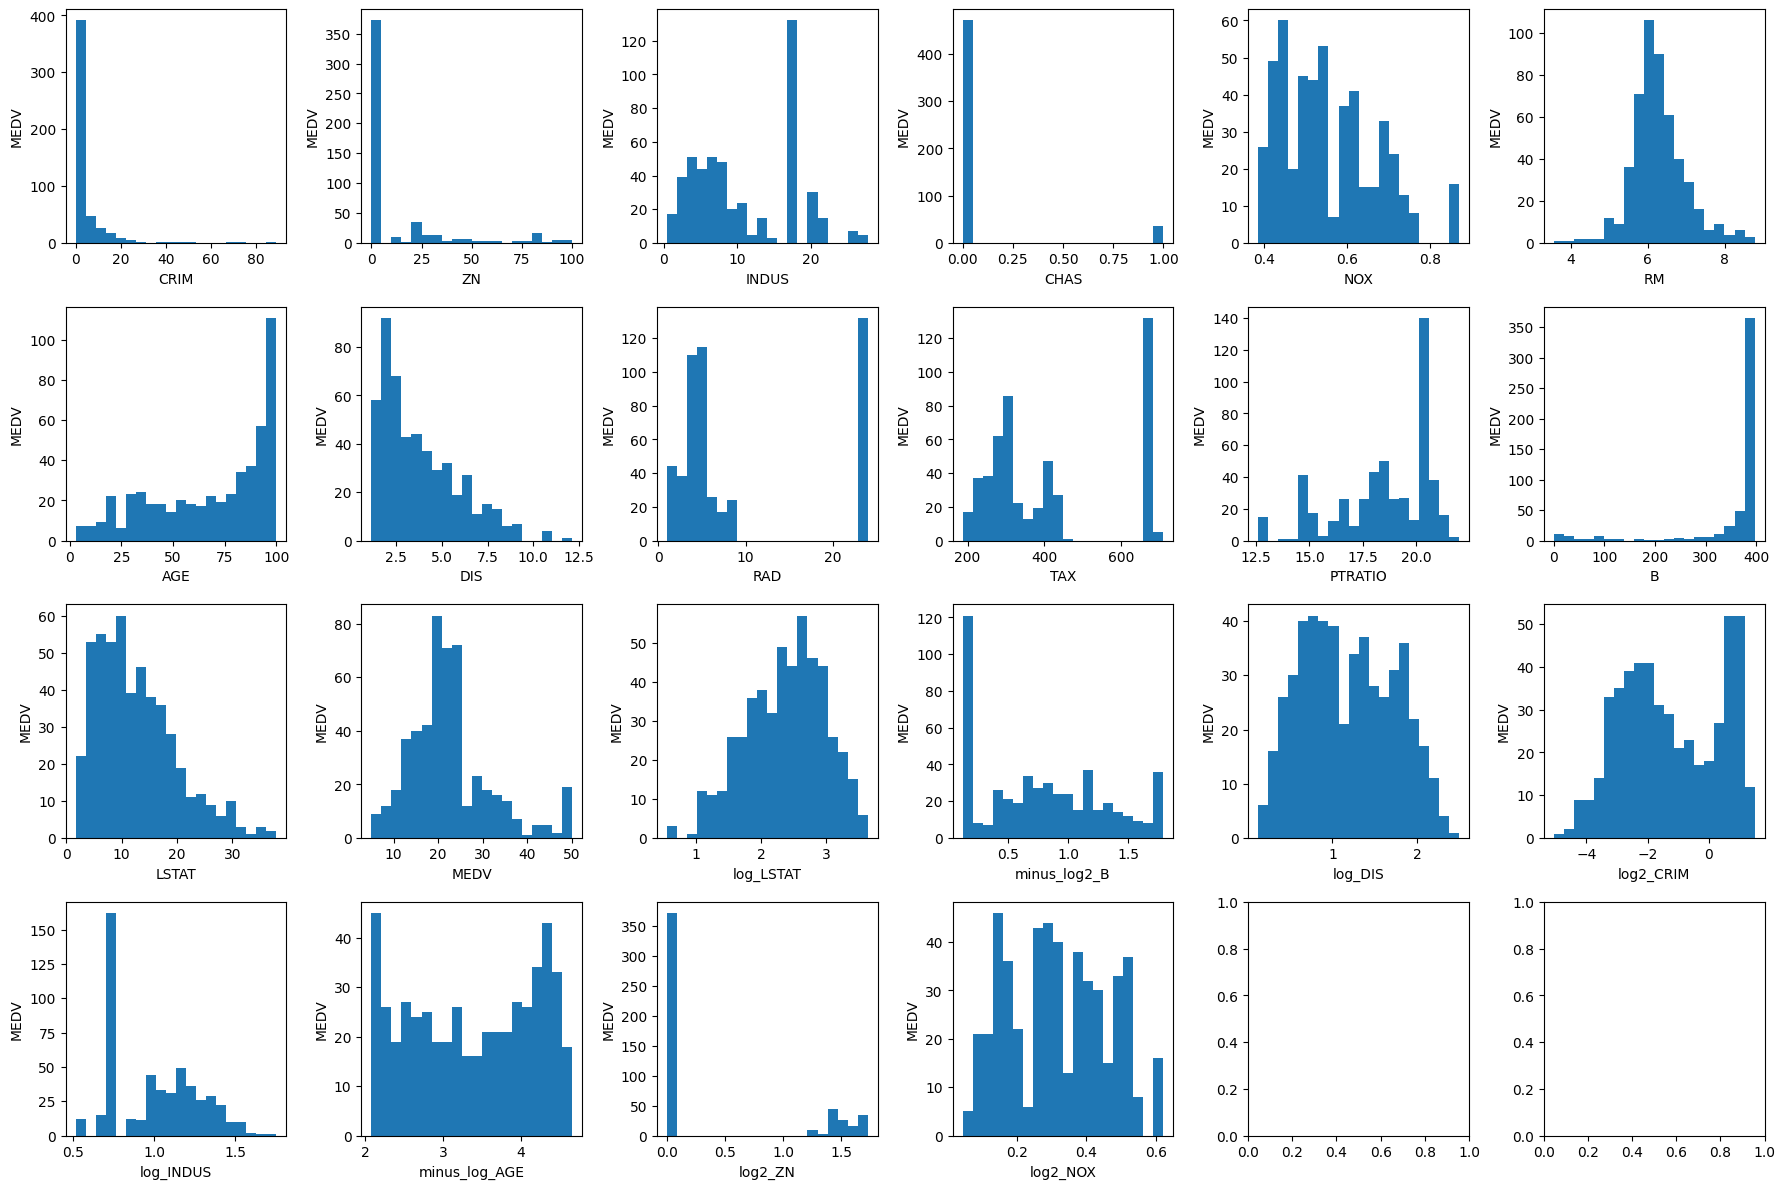

In [187]:
plot_hists(new_df)

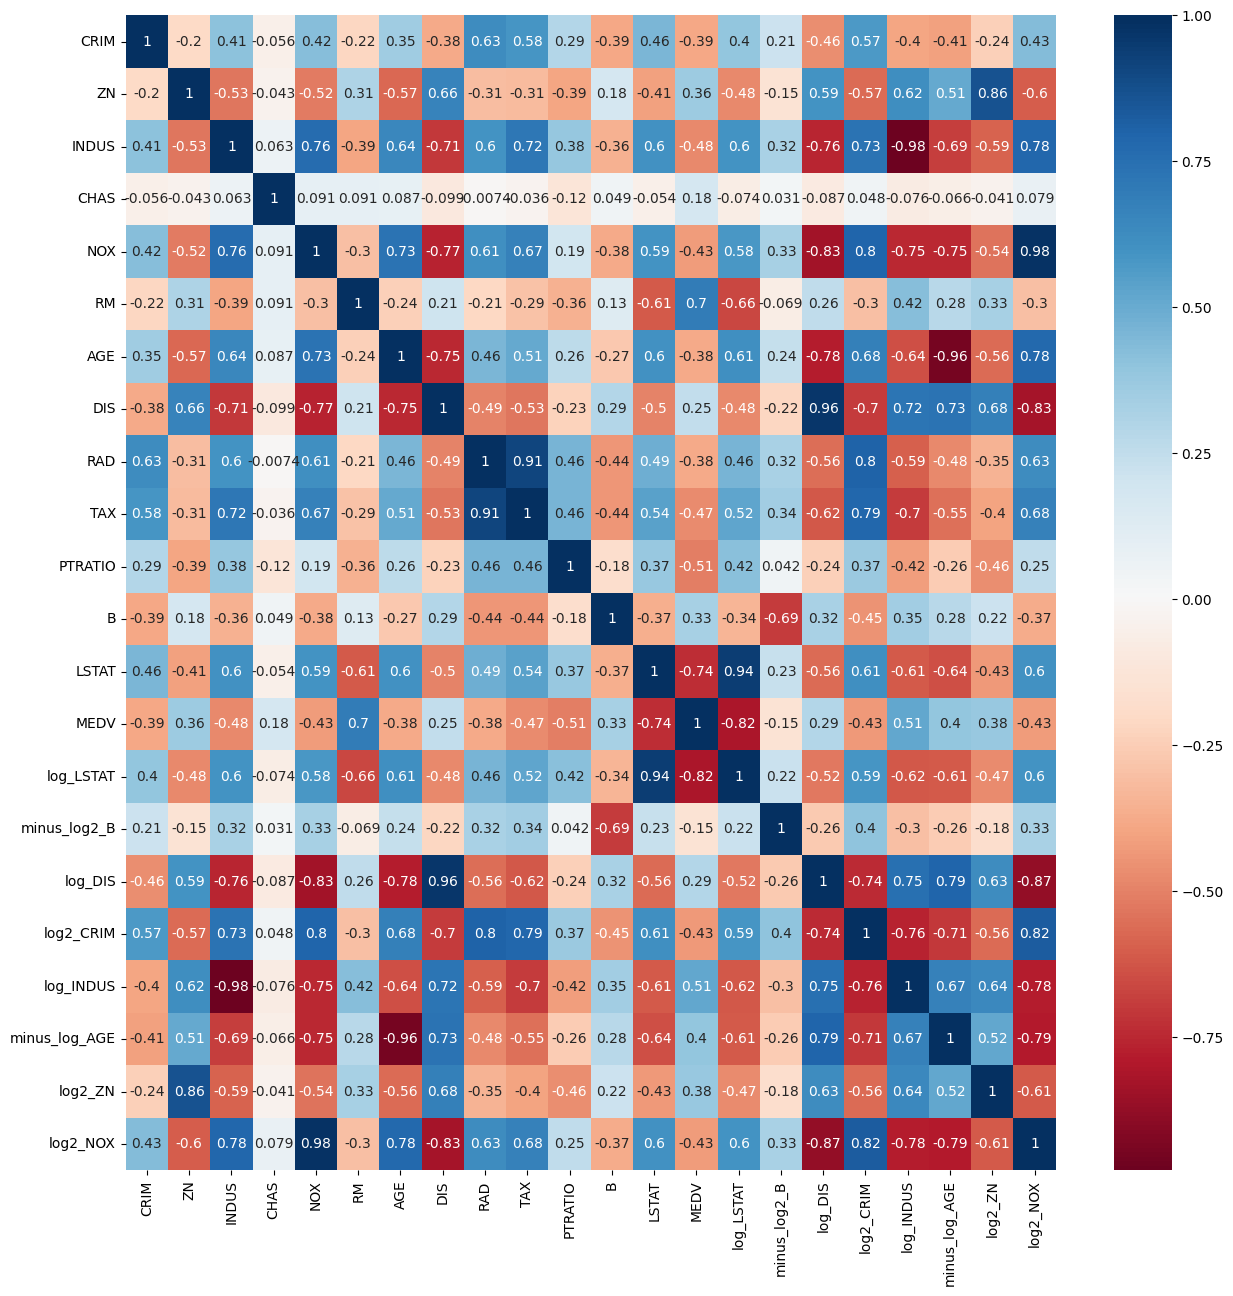

In [188]:
plt.figure(figsize=(15,15))
sns.heatmap(new_df.corr(),annot=True,cmap='RdBu',center=0)
plt.show()

Удаляем высоко кореллированные признаки

In [189]:
new_df.drop(['LSTAT','INDUS','NOX','DIS','AGE','ZN','RAD'],axis=1,inplace=True)

### Работа с выбросами

In [190]:
from collections import Counter

def IQR_method (df,n,features,minperc=25,maxperc=75):
    """
    Функция возвращающая индексы строк, которые в n столбцах выходят за IQR
    """
    outlier_list = []
    for column in features:
        perc1 = np.percentile(df[column], minperc)
        perc2 = np.percentile(df[column], maxperc)
        outlier_step = 1.5 * (perc2 - perc1)
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < perc1 - outlier_step) | (df[column] > perc2 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)    
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v >= n )
    # Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] < perc1 - outlier_step]
    df2 = df[df[column] > perc2 + outlier_step]
    
    print('Total number of outliers is:', np.count_nonzero(multiple_outliers))
    
    return multiple_outliers

In [213]:
X=new_df.copy()
y=X.pop('MEDV')
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)

Теоретически мы не можем выкидывать строчки из тестовой выборки, поэтому выбросы удалю только с тренировочной

In [214]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

outlier_indexes=IQR_method(X_train,2,X_train.columns)
X_train=X_train.drop(outlier_indexes,axis=0)
y_train=y_train.drop(outlier_indexes)

Total number of outliers is: 40


## Обучение моделей

In [171]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


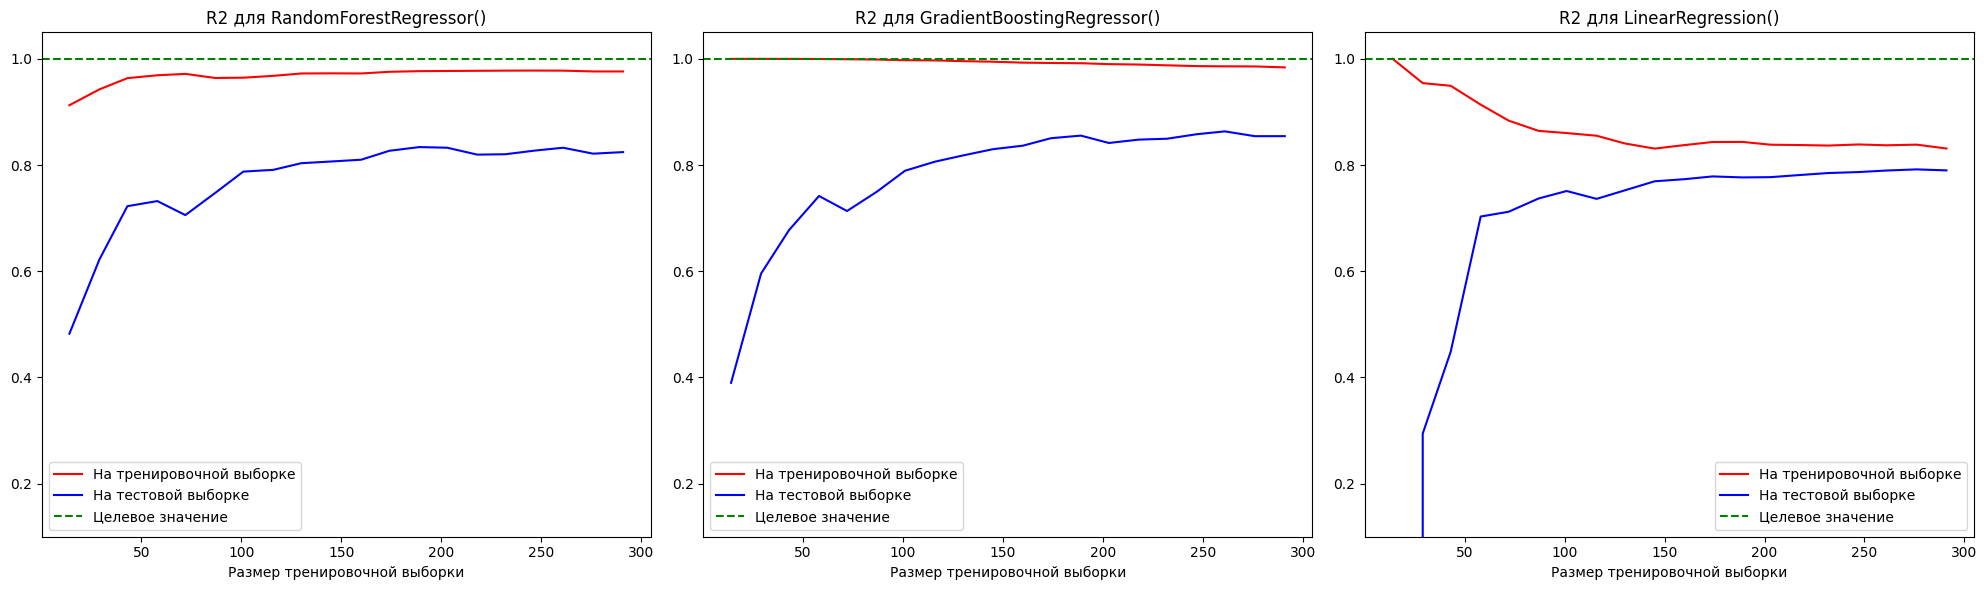

In [202]:

from sklearn.model_selection import learning_curve
train_sizes=np.linspace(0.05,1,20)

fig,axes=plt.subplots(1,3, figsize=(20,6))

i=0
models=[RandomForestRegressor(),GradientBoostingRegressor(),LinearRegression()]
for model in models:

    size,train_scores,test_scores=learning_curve(model,X_train,y_train,train_sizes=train_sizes,random_state=42,cv=5)

    train_scores_mean = np.mean(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)

    axes[i].plot(size,train_scores_mean,color='red',label='На тренировочной выборке')
    axes[i].plot(size,test_scores_mean,color='blue',label='На тестовой выборке')
    axes[i].axhline(1,linestyle='--',color='green',label='Целевое значение')


    axes[i].set_title(f'R2 для {model}')
    axes[i].set_xlabel('Размер тренировочной выборки')
    axes[i].legend()
    axes[i].set_ylim((0.1,1.05))
    
    i+=1


plt.tight_layout()
plt.show()
    


Вывод:RandomForest и GradientBoosting работают лучше, но склонны переобучаться. Линейная регрессия менее подвержена переобучению

### Часть 2. Lasso и Ridge регуляризация

In [216]:
from sklearn.linear_model import Lasso,Ridge
from sklearn.metrics import root_mean_squared_error,r2_score,explained_variance_score,mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score


lasso_regr=Lasso(alpha=1)
ridge_regr=Ridge(alpha=1)
linear_regr=LinearRegression()


models=[linear_regr,lasso_regr,ridge_regr]
scorers=[root_mean_squared_error,r2_score,explained_variance_score,mean_absolute_percentage_error]


for model in models:
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    
    print(f"Для модели {model}:")
    for scorer in scorers:
        score=scorer(y_test,y_pred)
        #score=np.mean(cross_val_score(model,X,y,scoring=make_scorer(scorer)))
        print(f'{scorer.__name__} = {score}')

    print('---------------------------')





Для модели LinearRegression():
root_mean_squared_error = 4.701196817484329
r2_score = 0.6986211461584243
explained_variance_score = 0.7067922743528998
mean_absolute_percentage_error = 0.16050351455314565
---------------------------
Для модели Lasso(alpha=1):
root_mean_squared_error = 4.873459409304095
r2_score = 0.6761300782449633
explained_variance_score = 0.6761641870805442
mean_absolute_percentage_error = 0.17043494079557578
---------------------------
Для модели Ridge(alpha=1):
root_mean_squared_error = 4.698543013779455
r2_score = 0.698961304040836
explained_variance_score = 0.7070993264233214
mean_absolute_percentage_error = 0.15982918069777363
---------------------------


Вывод: для данного датасета Ridge немного улучшает показатели, а Lasso немного ухудшает

In [219]:
lasso_regr=Lasso(alpha=0.5)
ridge_regr=Ridge(alpha=0.5)
linear_regr=LinearRegression()
coeffs=pd.DataFrame({"Feature":X.columns})

i=0
models=[linear_regr,lasso_regr,ridge_regr]
for model in models:
    model.fit(X_train,y_train)
    coeffs[model]=model.coef_

coeffs




,Feature,LinearRegression(),Lasso(alpha=0.5),Ridge(alpha=0.5)
0,CRIM,-1.780533,-0.657384,-1.770159
1,CHAS,0.651207,0.265387,0.652552
2,RM,3.430433,3.307449,3.431477
3,TAX,-0.744742,-0.039539,-0.742457
4,PTRATIO,-1.097900,-1.105882,-1.100406
5,B,1.624764,0.000000,1.614342
6,log_LSTAT,-4.193998,-4.171078,-4.189148
7,minus_log2_B,0.787870,0.000000,0.781821
8,log_DIS,-3.549646,-0.473122,-3.511498
9,log2_CRIM,1.636943,0.000000,1.614060


Как видим Lasso оставляет только некоторые признаки, а Ridge оставляет все признаки, но уменьшает их влияние на MEDV.

Так как в Lasso некоторые имеющие большой вклад признаки (такие как B) зануляются, значит они сильно скореллированы с другими признаками

In [ ]:
Lasso.fit()

### Реализация ElasticNet

In [236]:
class MyElasticNet(Lasso,Ridge):
    def __init__(self,alpha1,alpha2):
        self.lasso_model=Lasso(alpha=alpha1)
        self.ridge_model=Ridge(alpha=alpha2)

    def fit(self,X,y):
        self.lasso_model.fit(X,y)
        self.ridge_model.fit(X,y)
        



In [237]:
model=MyElasticNet(0.5,0.3)
model.fit(X_train,y_train)